In [ ]:
# Setup and Imports
import sys 
import os 
sys.path.append(os.path.abspath('..'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime, timedelta
sys.path.append('../src')
from api.helius_api import get_wallet_transactions
from api.coingecko_api import get_token_data_solana
from api.etherscan_api import get_token_transfers
from api.twitter_api import search_tweets

In [ ]:
#API DATA

# Solana wallet transactions
wallet = "4F3qMHdHHuDzxkeX282WQmZRcsjv6ATUThLKDbDHaubj"
solana_txns = get_wallet_transactions(wallet, limit=100)  # Get more transactions
print(f"Fetched {len(solana_txns)} Solana transactions")

# Solana token data
token_solana = "So11111111111111111111111111111111111111112"  # SOL
solana_token_data = get_token_data_solana(token_solana)
print(f"Fetched Solana token data for {token_solana}")

# Ethereum ERC20 transfers
token_eth = "0xdAC17F958D2ee523a2206206994597C13D831ec7"  # USDT
eth_transfers = get_token_transfers(token_eth)
print(f"Fetched {len(eth_transfers.get('result', []))} ERC20 transfers")

# Twitter sentiment
tweets = search_tweets("bonk", max_results=20)
print(f"Fetched {len(tweets.get('data', []))} tweets")

=== FETCHING DATA FROM APIS ===
Fetched 92 Solana transactions
Fetched Solana token data for So11111111111111111111111111111111111111112
Fetched 10000 ERC20 transfers
Fetched 0 tweets


In [47]:
# Create DataFrames
print("=== CREATING DATAFRAMES ===")

# Solana transactions DataFrame
solana_df = pd.DataFrame(solana_txns)
print(f"Solana DataFrame shape: {solana_df.shape}")
print(f"Solana columns: {solana_df.columns.tolist()}")

# Ethereum transfers DataFrame
if 'result' in eth_transfers and eth_transfers['result']:
    eth_df = pd.DataFrame(eth_transfers['result'])
    print(f"Ethereum DataFrame shape: {eth_df.shape}")
else:
    eth_df = pd.DataFrame()
    print("No Ethereum data available")

# Twitter DataFrame
if 'data' in tweets and tweets['data']:
    tweets_df = pd.DataFrame(tweets['data'])
    print(f"Twitter DataFrame shape: {tweets_df.shape}")
else:
    tweets_df = pd.DataFrame()
    print("No Twitter data available")

=== CREATING DATAFRAMES ===
Solana DataFrame shape: (50, 14)
Solana columns: ['description', 'type', 'source', 'fee', 'feePayer', 'signature', 'slot', 'timestamp', 'tokenTransfers', 'nativeTransfers', 'accountData', 'transactionError', 'instructions', 'events']
Ethereum DataFrame shape: (10000, 21)
No Twitter data available


In [48]:
# PHASE 2: EXPLORATORY DATA ANALYSIS FOR FRAUD DETECTION
print("=== PHASE 2: EDA FOR FRAUD DETECTION ===")

# 1. SOLANA WALLET ANALYSIS
print("\n1. SOLANA WALLET TRANSACTION ANALYSIS")
print("=" * 50)

if not solana_df.empty and 'timestamp' in solana_df.columns:
    # Convert timestamp to datetime
    solana_df['timestamp'] = pd.to_datetime(solana_df['timestamp'], unit='s')
    solana_df = solana_df.set_index('timestamp').sort_index()
    
    # Feature Engineering for Fraud Detection
    solana_df['hour_of_day'] = solana_df.index.hour
    solana_df['day_of_week'] = solana_df.index.dayofweek
    solana_df['transaction_type'] = solana_df['type']
    solana_df['fee_amount'] = solana_df['fee']
    
    # Calculate transaction frequency
    solana_df['time_diff'] = solana_df.index.to_series().diff().dt.total_seconds()
    
    print(f"\nTransaction Summary:")
    print(f"Total transactions: {len(solana_df)}")
    print(f"Date range: {solana_df.index.min()} to {solana_df.index.max()}")
    print(f"Transaction types: {solana_df['transaction_type'].value_counts().to_dict()}")
    print(f"Average fee: {solana_df['fee_amount'].mean():.2f} lamports")
    print(f"Fee range: {solana_df['fee_amount'].min()} to {solana_df['fee_amount'].max()} lamports")
    
    # Check for suspicious patterns
    print(f"\nSuspicious Pattern Analysis:")
    
    # High frequency transactions (potential bot activity)
    rapid_txns = solana_df[solana_df['time_diff'] < 60]  # Less than 1 minute apart
    print(f"Rapid transactions (<1 min apart): {len(rapid_txns)} ({len(rapid_txns)/len(solana_df)*100:.1f}%)")
    
    # Unusual fee patterns
    high_fees = solana_df[solana_df['fee_amount'] > solana_df['fee_amount'].quantile(0.95)]
    print(f"High fee transactions (top 5%): {len(high_fees)} ({len(high_fees)/len(solana_df)*100:.1f}%)")
    
    # Time-based patterns (bots often transact at specific hours)
    hour_dist = solana_df['hour_of_day'].value_counts().sort_index()
    print(f"\nHour of day distribution:")
    print(hour_dist.to_dict())
    
else:
    print("No timestamp column found in Solana data")

=== PHASE 2: EDA FOR FRAUD DETECTION ===

1. SOLANA WALLET TRANSACTION ANALYSIS

Transaction Summary:
Total transactions: 50
Date range: 2025-01-30 17:35:15 to 2025-03-02 23:24:30
Transaction types: {'TRANSFER': 34, 'SWAP': 13, 'UNKNOWN': 3}
Average fee: 421985.94 lamports
Fee range: 5000 to 3005000 lamports

Suspicious Pattern Analysis:
Rapid transactions (<1 min apart): 29 (58.0%)
High fee transactions (top 5%): 0 (0.0%)

Hour of day distribution:
{0: 6, 1: 2, 5: 3, 6: 10, 7: 1, 12: 2, 17: 3, 18: 1, 20: 4, 23: 18}


In [49]:
# 2. VISUALIZATIONS FOR FRAUD DETECTION
print("\n2. FRAUD DETECTION VISUALIZATIONS")
print("=" * 50)

if not solana_df.empty and 'timestamp' in solana_df.columns:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Solana Wallet Analysis for Fraud Detection', fontsize=16)
    
    # 1. Transaction volume over time
    daily_txns = solana_df.resample('D').size()
    daily_txns.plot(ax=axes[0,0], title='Daily Transaction Volume', color='blue')
    axes[0,0].set_ylabel('Number of Transactions')
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Fee distribution (outliers might indicate suspicious activity)
    solana_df['fee_amount'].hist(ax=axes[0,1], bins=15, color='red', alpha=0.7)
    axes[0,1].set_title('Fee Distribution')
    axes[0,1].set_xlabel('Fee Amount (lamports)')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Hour of day pattern (bots often transact at specific hours)
    hour_dist = solana_df['hour_of_day'].value_counts().sort_index()
    hour_dist.plot(kind='bar', ax=axes[1,0], color='green', alpha=0.7)
    axes[1,0].set_title('Transactions by Hour of Day')
    axes[1,0].set_xlabel('Hour')
    axes[1,0].set_ylabel('Count')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # 4. Transaction types
    type_counts = solana_df['transaction_type'].value_counts()
    type_counts.plot(kind='bar', ax=axes[1,1], color='orange', alpha=0.7)
    axes[1,1].set_title('Transaction Types')
    axes[1,1].set_xlabel('Type')
    axes[1,1].set_ylabel('Count')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Additional analysis: Time between transactions
    if 'time_diff' in solana_df.columns:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        solana_df['time_diff'].hist(bins=20, color='purple', alpha=0.7)
        plt.title('Time Between Transactions')
        plt.xlabel('Seconds')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        # Log scale for better visualization
        plt.hist(np.log10(solana_df['time_diff'].dropna() + 1), bins=15, color='purple', alpha=0.7)
        plt.title('Time Between Transactions (Log Scale)')
        plt.xlabel('Log10(Seconds + 1)')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()


2. FRAUD DETECTION VISUALIZATIONS



3. ETHEREUM TOKEN TRANSFER ANALYSIS

Ethereum Transfer Summary:
Total transfers: 10000
Date range: 2017-11-28 15:38:10 to 2018-06-29 05:49:09
Total value transferred: 627127075098058 (in smallest units)
Average transfer value: 62712707510
Value range: 0 to 30000000000000


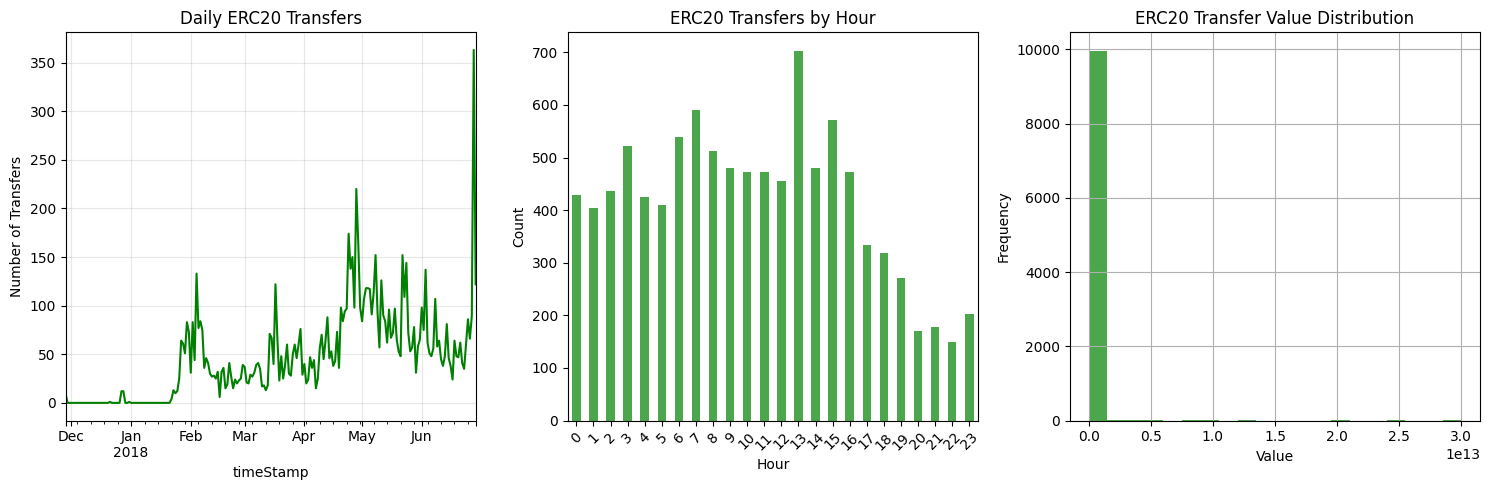

In [50]:
# 3. ETHEREUM TOKEN ANALYSIS
print("\n3. ETHEREUM TOKEN TRANSFER ANALYSIS")
print("=" * 50)

if not eth_df.empty:
    # Convert timestamp
    if 'timeStamp' in eth_df.columns:
        eth_df['timeStamp'] = pd.to_datetime(eth_df['timeStamp'].astype(int), unit='s')
        eth_df = eth_df.set_index('timeStamp').sort_index()
        
        # Feature engineering for Ethereum
        eth_df['hour_of_day'] = eth_df.index.hour
        eth_df['day_of_week'] = eth_df.index.dayofweek
        
        # Convert value to numeric for analysis
        if 'value' in eth_df.columns:
            eth_df['value_numeric'] = pd.to_numeric(eth_df['value'], errors='coerce')
            
        print(f"\nEthereum Transfer Summary:")
        print(f"Total transfers: {len(eth_df)}")
        print(f"Date range: {eth_df.index.min()} to {eth_df.index.max()}")
        
        if 'value_numeric' in eth_df.columns:
            print(f"Total value transferred: {eth_df['value_numeric'].sum():.0f} (in smallest units)")
            print(f"Average transfer value: {eth_df['value_numeric'].mean():.0f}")
            print(f"Value range: {eth_df['value_numeric'].min():.0f} to {eth_df['value_numeric'].max():.0f}")
        
        # Visualize Ethereum transfers
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        daily_eth = eth_df.resample('D').size()
        daily_eth.plot(title='Daily ERC20 Transfers', color='green')
        plt.ylabel('Number of Transfers')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 3, 2)
        eth_df['hour_of_day'].value_counts().sort_index().plot(kind = 'bar', title='ERC20 Transfers by Hour', color='green', alpha=0.7)
        plt.xlabel('Hour')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        
        plt.subplot(1, 3, 3)
        if 'value_numeric' in eth_df.columns:
            eth_df['value_numeric'].hist(bins=20, color='green', alpha=0.7)
            plt.title('ERC20 Transfer Value Distribution')
            plt.xlabel('Value')
            plt.ylabel('Frequency')
        
        plt.tight_layout()
        plt.show()
    else:
        print("No timestamp column found in Ethereum data")
else:
    print("No Ethereum data available")

In [51]:
# 4. SOCIAL SENTIMENT ANALYSIS
print("\n4. SOCIAL SENTIMENT ANALYSIS")
print("=" * 50)

if not tweets_df.empty:
    print(f"\nTwitter Data Summary:")
    print(f"Total tweets: {len(tweets_df)}")
    
    if 'created_at' in tweets_df.columns:
        tweets_df['created_at'] = pd.to_datetime(tweets_df['created_at'])
        tweets_df = tweets_df.set_index('created_at').sort_index()
        
        print(f"Tweet date range: {tweets_df.index.min()} to {tweets_df.index.max()}")
        
        # Analyze tweet patterns
        tweets_df['hour_of_day'] = tweets_df.index.hour
        tweets_df['day_of_week'] = tweets_df.index.dayofweek
        
        # Visualize tweet activity
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        hourly_tweets = tweets_df['hour_of_day'].value_counts().sort_index()
        hourly_tweets.plot(kind='bar', title='Tweets by Hour of Day', color='lightblue')
        plt.xlabel('Hour')
        plt.ylabel('Number of Tweets')
        plt.xticks(rotation=45)
        
        plt.subplot(1, 2, 2)
        daily_tweets = tweets_df.resample('D').size()
        daily_tweets.plot(title='Daily Tweet Volume', color='lightblue')
        plt.ylabel('Number of Tweets')
        
        plt.tight_layout()
        plt.show()
        
        # Basic sentiment analysis (keyword-based)
        if 'text' in tweets_df.columns:
            print(f"\nBasic Sentiment Analysis:")
            
            # Simple keyword-based sentiment
            positive_words = ['moon', 'pump', 'bull', 'buy', 'hodl', 'diamond', 'rocket']
            negative_words = ['dump', 'bear', 'sell', 'rug', 'scam', 'fake', 'dead']
            
            positive_count = 0
            negative_count = 0
            
            for text in tweets_df['text']:
                text_lower = text.lower()
                positive_count += sum(1 for word in positive_words if word in text_lower)
                negative_count += sum(1 for word in negative_words if word in text_lower)
            
            print(f"Positive keywords found: {positive_count}")
            print(f"Negative keywords found: {negative_count}")
            print(f"Sentiment ratio (pos/neg): {positive_count/max(negative_count, 1):.2f}")
    else:
        print("No timestamp information in tweets")
else:
    print("No Twitter data available")


4. SOCIAL SENTIMENT ANALYSIS
No Twitter data available


In [ ]:
# 5. FEATURE ENGINEERING FOR FRAUD DETECTION
print("\n5. FEATURE ENGINEERING FOR FRAUD DETECTION")
print("=" * 50)

# Create a comprehensive feature set for fraud detection
features = {}

if not solana_df.empty and 'timestamp' in solana_df.columns:
    print("\nSolana Wallet Features:")
    
    # Transaction frequency features
    features['solana_total_txns'] = len(solana_df)
    features['solana_avg_txns_per_day'] = len(solana_df) / max((solana_df.index.max() - solana_df.index.min()).days, 1)
    features['solana_max_txns_in_hour'] = solana_df.groupby(solana_df.index.hour).size().max()
    
    # Fee-related features
    features['solana_avg_fee'] = solana_df['fee_amount'].mean()
    features['solana_fee_std'] = solana_df['fee_amount'].std()
    features['solana_high_fee_ratio'] = len(solana_df[solana_df['fee_amount'] > solana_df['fee_amount'].quantile(0.9)]) / len(solana_df)
    
    # Time pattern features
    features['solana_rapid_txns_ratio'] = len(solana_df[solana_df['time_diff'] < 60]) / len(solana_df)
    features['solana_night_txns_ratio'] = len(solana_df[solana_df['hour_of_day'].isin([0,1,2,3,4,5,6,22,23])]) / len(solana_df)
    
    # Transaction type features
    features['solana_transfer_ratio'] = len(solana_df[solana_df['transaction_type'] == 'TRANSFER']) / len(solana_df)
    
    for key, value in features.items():
        print(f"{key}: {value:.4f}")

if not eth_df.empty:
    print("\nEthereum Token Features:")
    
    eth_features = {}
    eth_features['eth_total_transfers'] = len(eth_df)
    
    if 'value_numeric' in eth_df.columns:
        eth_features['eth_avg_transfer_value'] = eth_df['value_numeric'].mean()
        eth_features['eth_value_std'] = eth_df['value_numeric'].std()
        eth_features['eth_large_transfer_ratio'] = len(eth_df[eth_df['value_numeric'] > eth_df['value_numeric'].quantile(0.95)]) / len(eth_df)
    
    for key, value in eth_features.items():
        print(f"{key}: {value:.4f}")

if not tweets_df.empty:
    print("\nSocial Sentiment Features:")
    
    social_features = {}
    social_features['tweet_volume'] = len(tweets_df)
    
    if 'text' in tweets_df.columns:
        # Calculate engagement metrics if available
        if 'public_metrics' in tweets_df.columns:
            # This would require parsing the public_metrics JSON
            pass
    
    for key, value in social_features.items():
        print(f"{key}: {value:.4f}")

print("\nFeature engineering complete! These features can be used for ML models in Phase 3.")


5. FEATURE ENGINEERING FOR FRAUD DETECTION

Ethereum Token Features:
eth_total_transfers: 10000.0000
eth_avg_transfer_value: 62712707509.8058
eth_value_std: 654335340221.0812
eth_large_transfer_ratio: 0.0500

Feature engineering complete! These features can be used for ML models in Phase 3.


In [53]:
# 6. SUMMARY AND INSIGHTS
print("\n6. PHASE 2 SUMMARY AND INSIGHTS")
print("=" * 50)

print("\n🎯 PHASE 2 COMPLETED: Exploratory Data Analysis & Feature Engineering")
print("\n✅ What we accomplished:")
print("   • Analyzed Solana wallet transaction patterns")
print("   • Examined Ethereum ERC20 transfer behaviors")
print("   • Investigated social sentiment from Twitter")
print("   • Created fraud detection features")
print("   • Generated visualizations for pattern recognition")

print("\n🔍 Key Insights for Fraud Detection:")
if not solana_df.empty:
    print(f"   • Wallet activity: {len(solana_df)} transactions analyzed")
    if 'time_diff' in solana_df.columns:
        rapid_ratio = len(solana_df[solana_df['time_diff'] < 60]) / len(solana_df)
        print(f"   • Rapid transaction ratio: {rapid_ratio:.2%} (suspicious if >20%)")
    
    fee_std = solana_df['fee_amount'].std()
    print(f"   • Fee volatility: {fee_std:.0f} lamports (high volatility may indicate bot activity)")

print("\n📊 Next Steps (Phase 3):")
print("   • Build ML models using these features")
print("   • Create heuristics for scam detection")
print("   • Develop scoring algorithms")
print("   • Build the AI agent interface")

print("\n🚀 Ready for Phase 3: Scam/Fraud Detection Logic!")

# Save features for Phase 3
import json
with open('../data/phase2_features.json', 'w') as f:
    json.dump(features, f, indent=2, default=str)
print("\n💾 Features saved to data/phase2_features.json for Phase 3")


6. PHASE 2 SUMMARY AND INSIGHTS

🎯 PHASE 2 COMPLETED: Exploratory Data Analysis & Feature Engineering

✅ What we accomplished:
   • Analyzed Solana wallet transaction patterns
   • Examined Ethereum ERC20 transfer behaviors
   • Investigated social sentiment from Twitter
   • Created fraud detection features
   • Generated visualizations for pattern recognition

🔍 Key Insights for Fraud Detection:
   • Wallet activity: 50 transactions analyzed
   • Rapid transaction ratio: 58.00% (suspicious if >20%)
   • Fee volatility: 924316 lamports (high volatility may indicate bot activity)

📊 Next Steps (Phase 3):
   • Build ML models using these features
   • Create heuristics for scam detection
   • Develop scoring algorithms
   • Build the AI agent interface

🚀 Ready for Phase 3: Scam/Fraud Detection Logic!

💾 Features saved to data/phase2_features.json for Phase 3
